C:\Users\tghyw\AppData\Local\Temp\ipykernel_26376\2530445182.py:26: RuntimeWarning: invalid value encountered in scalar divide
  Lambda_star = (np.log(((-param-2)*(r0**(-2)-raddist**(-2)))/(2 * (raddist**(-param-2)-r0**(-param-2)))))/(np.log(raddist))


0.000216
0.0002160000049356199
0.0002160000096559526
0.000216
0.00021599999992790158
0.0002159999987525383
0.00021599999700099975
0.00021600007651335215
0.0002160003182644285
0.00021600049347238765
0.00021600049347296097
0.00021600125861156368
0.0002160036761668543
0.00021600542830567355
0.00021600125861156964
0.0002160036761668957
0.00021600542830591652
0.00021600542830591652
0.00021601308018384045
0.00021603725952024268
0.00021605478454502793
0.00021601308024302203
0.0002160372599334908
0.00021605478697200167
0.0002160547869720688
0.00021613132782561582
0.00021636904736639344
0.0002165253605072732
0.00021613191122499492
0.00021637316323389736
0.0002165493405190727
0.0002165494072896771
0.00021680850616842898
0.00021674399342126824
0.00021422268922998545
0.0002168883828055593
0.00021760504064842086
0.000218112690475826
0.00021689976826364438
0.00021761090329363588
0.00021829154982614575
0.00021829636506888654
0.00021829636003110385
0.0002182964122771429
0.0002185025872923735
0.0002172

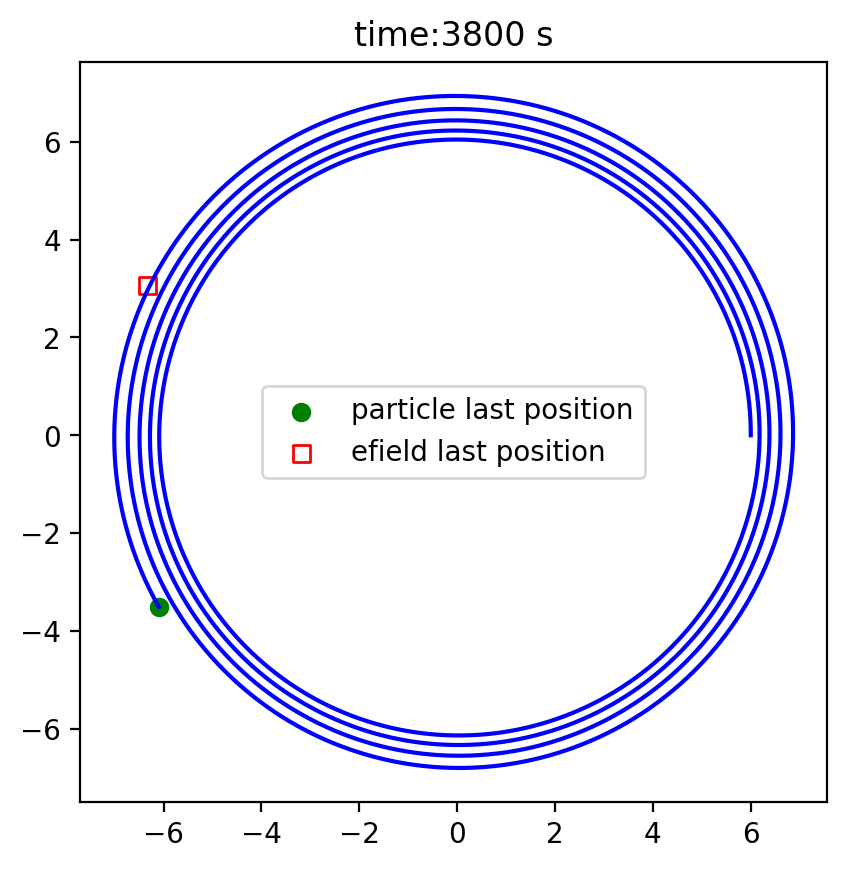

In [269]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import math

# 当径向的电漂移速度设置为常数的情况
x0 = np.array([6, 0])
r0 = np.linalg.norm(x0)

param = 0.52
tangvelvalue = 0.02
E0 = 1e-6
Lambda_star = 0.25
phis = []
Es = []
def ptcv(t,y):
    raddist = np.linalg.norm(y)
    unitvec = y / raddist
    perpvec = np.array([-unitvec[-1], unitvec[0]])
    tangvel = perpvec * tangvelvalue * raddist ** (-param+1)
    coordx = y[0]
    coordy = y[1]
    theta = math.atan2(coordy, coordx)
    phi0 = np.pi/2
    tau = 2 * np.pi * r0 / (tangvelvalue * r0 ** (-param+1))
    Lambda_star = (np.log(((-param-2)*(r0**(-2)-raddist**(-2)))/(2 * (raddist**(-param-2)-r0**(-param-2)))))/(np.log(raddist))
    if np.isnan(Lambda_star):
        Lambda_star = param
    # # omega = 2 * np.pi / tau * (r0/raddist) ** Lambda_star # wrong
    vfact = tangvelvalue * r0 ** (1-param) / (r0 ** (1-Lambda_star))
    vfact = tangvelvalue
    omega = vfact * raddist**(-Lambda_star)
    E = E0 * np.sin(omega * t - theta + phi0) 
    # E = 1e-6
    radvel = unitvec * raddist**3 *  E
    print(raddist**3 *  E)
    phis.append(np.mod(np.rad2deg(omega * t - theta + phi0), 360))
    Es.append(E)
    vel = np.add(tangvel, radvel)
    return vel

def efieldv(t, y):
    raddist = np.linalg.norm(y)
    unitvec = y / raddist        
    perpvec = np.array([-unitvec[-1], unitvec[0]])
    # 计算理论上电场传播速度相关的Lambda*的值
    # Lambda_star = (np.log(raddist**param - r0**param) - np.log(param*(raddist-r0)))/np.log(raddist) + 1
    # Lambda_star = (np.log(((-param-2)*(r0**(-2)-raddist**(-2)))/(2 * (raddist**(-param-2)-r0**(-param-2)))))/(np.log(raddist))
    tangvel = perpvec * tangvelvalue * raddist ** (-Lambda_star+1)
    # print(np.linalg.norm(tangvel))
    return tangvel

# def thetacal(y, t, Lambda):
#     raddist = np.linalg.norm(y)
#     path = 0.1 * raddist ** Lambda * t
#     theta = path / raddist
#     return np.mod(np.rad2deg(theta), 360)

def event_func(t, y):
    return y[0] - 3

event_func.terminal = True
event_func.direction = 0

t0 = 0
t_end = 3800
y0 = x0
sol = solve_ivp(
    ptcv,
    [t0, t_end],
    y0,
    method='Radau',
    t_eval=np.linspace(t0, t_end, 10000),
)

final_point = np.array([sol.y[0][-1], sol.y[1][-1]])
sol2 = solve_ivp(
    efieldv,
    [t0, t_end],
    np.array([np.linalg.norm(final_point), 0]),
    method='Radau',
    t_eval=np.linspace(t0, t_end, 10000)
)
final_point2 = np.array([sol2.y[0][-1], sol2.y[1][-1]])


# print("理论上最外圈电场最大相位位置：",thetacal(final_point, t_end, 0.5794))
print("实际最外圈电场相位位置",np.mod(np.rad2deg(math.atan2(final_point2[1], final_point2[0])) + 360, 360) )
print("粒子最终位置",np.mod(np.rad2deg(math.atan2(final_point[1], final_point[0])) + 360, 360) )
print("径向距离：", np.linalg.norm(final_point))
fig, ax = plt.subplots(dpi=200)
ax.plot(sol.y[0], sol.y[1], c='b')
# ax.plot(sol2.y[0], sol2.y[1], c='r')
ax.scatter(final_point[0], final_point[1], c='g', label='particle last position')
ax.scatter(final_point2[0], final_point2[1], label='efield last position', marker='s', edgecolor='r', facecolor='none')
ax.set_title("time:{} s".format(t_end))
ax.legend()
ax.set_aspect('equal', 'box')

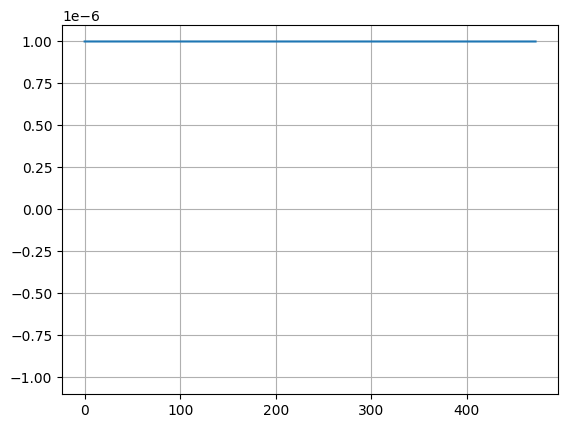

In [270]:
window_size = 30

# 计算移动平均
Es = np.convolve(Es, np.ones(window_size)/window_size, mode='valid')
plt.plot(Es[:])
plt.ylim(-1.1e-6, 1.1e-6)
plt.grid()

In [123]:
# 模拟类
import time
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import random
import scipy as sp
from scipy import constants as C
from scipy.constants import physical_constants as PC
from scipy import stats as st
from scipy.special import erf
import math
import os
# import scienceplots
# import PyGeopack as gp
import copy
import matplotlib.animation as animation
from matplotlib import pyplot as plt
from matplotlib import cm, ticker
import matplotlib.patches as patches

class prt_sim(object):

    q = C.elementary_charge  # proton charge /Cb
    mu = C.proton_mass  # proton mass /kg
    Re = 0.6371E7  # one Earth Radius /m
    # Aw0 = (twopi / 0.864E-5) * 1E-8  # Angular velosity of earth
    c = C.speed_of_light  # speed of light /m/s

    def __init__(self, input_parameters, pulse_parameters, background_parameters):
        input_parameters = copy.deepcopy(input_parameters)
        pulse_parameters = copy.deepcopy(pulse_parameters)
        background_parameters = copy.deepcopy(background_parameters)
        
        self.input_parameters = input_parameters
        self.background_parameters = background_parameters
        self.pulse_parameters = pulse_parameters

    @property
    def input_parameters(self):
        return self._input_parameters

    @input_parameters.setter
    def input_parameters(self, value):
        if not isinstance(value, dict):
            raise TypeError("input parameters have to be dict type")
        
        allowed_keys = ["xmu", 'IOPT', 'raddist0', 'longi0', 'KEc0', 'pa',
                        'timedir', 'Tout', 'Dmin', 'pulse_flag', 'tmax', 'model', 'date']
        # 电荷正负，地磁扰动指数IOPT，粒子初始位置，经度，粒子初始动能，模拟时间步长，结果输出
        # 时间，最小距离步长，脉冲电场指示，最大模拟时间, 磁场模型, 日期（磁场模型中使用）

        for key in value.keys():
            if key not in allowed_keys:
                raise ValueError(f'key "{key}" is not allowed') 
            
        self._input_parameters = value

    @property
    def background_parameters(self):
        return self._background_parameters
    
    @background_parameters.setter
    def background_parameters(self, value):
        if not isinstance(value, dict):
            raise TypeError("pulse parameters have to be dict type")
        
        allowed_keys = ['phi0', 'E0', 'omega', 'guass_flag', 'random_phi_flag']
        for key in value.keys():
            if key not in allowed_keys:
                raise ValueError(f'key "{key}" is not allowed') 
            
        self._background_parameters = value

    @property
    def pulse_parameters(self):
        return self._pulse_parameters

    @pulse_parameters.setter
    def pulse_parameters(self, value):
        if not isinstance(value, dict):
            raise TypeError("pulse parameters have to be dict type")
        
        allowed_keys = ['phi0', 'E0', 'c0', 'c1', 'c2', 'c3', 'p', 'va', 'ri', 'ti', 'di', 'rd', 'vpulse']

        for key in value.keys():
            if key not in allowed_keys:
                raise ValueError(f'key "{key}" is not allowed') 
            
        self._pulse_parameters = value


    def prt_sim(self): # 一个粒子的模拟
        KEc0 = self.input_parameters.get("KEc0") # 粒子
        longi0 = self.input_parameters.get("longi0") # 初始位置经度
        raddist0 = self.input_parameters.get("raddist0") # 初始L值
        pa = self.input_parameters.get("pa") # 投掷角

        if self.input_parameters.get("xmu") == -1: # 电子
            m0 = C.electron_mass # 质量
            qabs = np.abs(C.elementary_charge) # 电荷
        elif self.input_parameters.get("xmu") == 1: # 质子
            m0 = C.proton_mass
            qabs = np.abs(C.elementary_charge)

        IOPT = self.input_parameters.get("IOPT")
        tmax = self.input_parameters.get("tmax")

        # depend of external magnetic field model(MOD), OPPT = kp + 1
        kp = IOPT - 1 # kp index 

        tilt = 0 # tilt angle
        
        # 初始位置转换为直角坐标系下（MAG)
        xc0 = raddist0 * np.cos(np.deg2rad(longi0))
        yc0 = raddist0 * np.sin(np.deg2rad(longi0))
        zc0 = 0 # 只考虑磁赤道电子
        mlt0 = np.mod(np.rad2deg(math.atan2(-1 * yc0, -1 * xc0)/15)+24, 24) # 初始磁地方时
        KEc0joule = KEc0 * 1000 * qabs  # energy in Joule
        
        # Calculating magnetic filed at position ptc0=(xc0, yc0, zc0)
        pulse_flag = self.input_parameters.get("pulse_flag")
        Bdx, Bdy, Bdz = self.MAG(tilt, xc0, yc0, zc0) # magnetic field using inferred model in GSM coordinates
        Ew1, Bu1 = self.pulse_fields(pulse_flag, 0, xc0, yc0, zc0) # pulse E field and pertubated B field  
        # Ew1_a, Bu1_a = pulse_fields_v0()

        Bx = Bdx + Bu1[0] * 1E9
        By = Bdy + Bu1[1] * 1E9
        Bz = Bdz + Bu1[2] * 1E9
        Bt = np.sqrt(Bx**2 + By**2 + Bz**2) # 总磁场，包含背景模型磁场  

        # ptc0: position-vector of initial gyrocenter, GSM coordinates

        ptc0 = np.array([xc0, yc0, zc0])

        # total energy = kinetic energy + rest energy

        Wtotjoule = KEc0joule + m0 * self.c ** 2

        # particle momnetum, from: W**2 = (P*C)**2 + (m0*c**2)**2

        ptotal2 = (Wtotjoule**2 - (m0 * self.c**2)**2) / self.c**2
        pperp2 = ptotal2 * (np.sin(np.deg2rad(pa)))**2
        # relativistic energy factor, gamma = (KE + m0*c**2)/(m0*c**2)

        gamma = (KEc0joule + m0 * self.c**2)/(m0 * self.c**2)
        Mr = pperp2 / (2 * m0 * Bt * qabs)  # first adiabatic invariant eV/nT

        rgc_o = np.multiply(ptc0, self.Re) # m
        VD_o, Wtot = self.DERIV(0, rgc_o, tilt, m0, Mr, qabs)
        VDmag = np.sqrt(np.dot(VD_o, VD_o)) # 漂移速度大小

        # initial time step, dt:
        dphi = 3  # this is the initial change in phi per time step, in degrees
        rad_dist = raddist0
        dt = dphi * 2 * np.pi * rad_dist * self.Re / (360 * VDmag)

        istop = 0
        time = 0
        equ0 = np.zeros(3) # 初始化赤道映射点的位置

        rgc_oRE_list = []
        w_list = []
        t_list = []
        i = 0
        while istop == 0:
            rgc_oRE = np.multiply(rgc_o, 1/self.Re)    
            rgc_oRE_list.append(rgc_oRE)
            w_list.append(Wtot)
            t_list.append(time)        

            timeT = time
            rgc_n = self.RK4(rgc_o, VD_o, time, dt, tilt, m0, Mr, qabs)
            VD_n, Wtot = self.DERIV(time, rgc_n, tilt, m0, Mr, qabs)
            VD_oRE = np.multiply(VD_o, 1/self.Re)
            VD_nRE = np.multiply(VD_n, 1/self.Re)            

            rgc_o = rgc_n
            time = timeT + dt            
            VD_o, Wtot = self.DERIV(time, rgc_o, tilt, m0, Mr, qabs)    
            rgc_nRE = np.multiply(rgc_n, 1/self.Re)
            equ = rgc_nRE # 赤道位置
            phi_gc = np.mod(np.rad2deg(math.atan2(equ[1], equ[0])) + 360, 360) # 经度

            Bdx, Bdy, Bdz = self.MAG(tilt, equ[0], equ[1], equ[2])
            Ew1, Bu1 = self.pulse_fields(pulse_flag, time, equ[0], equ[1], equ[2])
            # pulse_fields_v0()
            Btotx = Bdx + Bu1[0] * 1E9
            Btoty = Bdy + Bu1[1] * 1E9
            Btotz = Bdz + Bu1[2] * 1E9
            Btequ = np.sqrt(Btotx**2 + Btoty**2 + Btotz**2)
            sinpequ = 1
            pequ = np.rad2deg(np.arcsin(sinpequ))

            # condition for output: minimum distance Dmin
            D2 = (equ[0] - equ0[0])**2 + (equ[1] -
                                        equ0[1])**2 + (equ[2] - equ0[2])**2
            Dist = np.sqrt(D2)
            # If Dsit < Dmin

            # rgc_oRE = np.multiply(rgc_o, 1/self.Re)
            VD_oRE = np.multiply(VD_o, 1/self.Re)
            rad_dist = np.sqrt(equ[0]**2 + equ[1]**2)
            ptot2_inst = (Wtot**2 - (m0*self.c**2)**2)/self.c**2
            Mr_inst = ptot2_inst / (2 * m0 * Btequ * qabs)
            KE_inst_keV = (Wtot-(m0*self.c**2))/(1000*qabs)
            gamma_inst = Wtot/(m0 * self.c**2)
            # veloc_inst
            # veloc_fact

            equ0 = equ

            # Mr = Mr_inst
            gamma = gamma_inst

            time_c = time / 60
            r_c = rad_dist

            i += 1
            if((time_c >= 40) and (r_c >= 13.5)):
                print("r out of range")
                istop = 1

            # Max running time:
            if(time_c >= tmax):
                print(time_c)
                print("max running time")
                istop = 1
            # Rmax on night side:
            if((equ[0] < 0) and (r_c >= 18)):
                print("rmax night side")
                istop = 1

            # Rmax on day side:
            if((equ[1] >= 0) and (r_c >= 20)):
                print("rmax day side")
                istop = 1

            # Rmin (about same for nightside and dayside)
            if(r_c <= 3):
                print("rmin")
                istop = 1                
        return rgc_oRE_list, t_list, w_list

    def MAG(self, tilt, x, y, z):
        # 默认gsm坐标系下偶极场
        #  待添加其他模型
        PS = np.deg2rad(tilt)
        SPS = np.sin(PS)
        CPS = np.cos(PS)
        PSI = PS
        M = 1
        P = x ** 2
        U = z ** 2
        V = 3 * z * x
        T = y ** 2
        Q = 0.7 * 0.31E5 / np.sqrt(P + T + U) ** 5
        Bx = Q * ((T + U - 2 * P) * SPS - V * CPS)
        By = -3 * y * Q * (x * SPS + z * CPS)
        Bz = Q * ((P + T - 2 * U) * CPS - V * SPS)
        Bx = 0
        By = 0
        Bz = 0.311 * (np.sqrt(x**2 + y**2))**(-3) * 1e5
        return Bx, By, Bz
    

    def pulse_fields(self, pulse_flag, t, x, y, z):
        # pulse fields calculate
        # input pulse_flag(=0,1,2), t(sec), x,y,z(Re)
        # return Epulse[3] (V/m), Bpulse[3] (Tesla)

        rv = np.float32(np.array([x, y, z]))
        Epulse = np.zeros_like(rv)
        Bpulse = np.zeros_like(rv)
        if pulse_flag == 0:
            return Epulse, Bpulse

        elif pulse_flag == 1:
            phi0 = self.pulse_parameters.get("phi0")
            E0 = self.pulse_parameters.get("E0")
            c0 = self.pulse_parameters.get("c0")
            c1 = self.pulse_parameters.get("c1")
            c2 = self.pulse_parameters.get("c2")
            c3 = self.pulse_parameters.get("c3")
            p = self.pulse_parameters.get("p")
            va = self.pulse_parameters.get("va")
            ri = self.pulse_parameters.get("ri")
            ti = self.pulse_parameters.get("ti")
            di = self.pulse_parameters.get("di")
            rd = self.pulse_parameters.get("rd") 
            vpulse = self.pulse_parameters.get("vpulse")
        else:
            raise TypeError(r"pulse flag must be 0 or 1")
        pulse_temp = {
            "phi0": phi0,
            "E0": E0,
            "c0": c0,
            "c1": c1,
            "c2": c2,
            "c3": c3,
            "p": p,
            "va": va,
            "ri": ri,
            "ti": ti,
            "di": di,
            "rd": rd,
            'vpulse':vpulse
        }       
        # calculate the unit vectors in spherical coord at r = (x, y, z):

        er, eu, ew = self.UNIT_Sph(rv)
        # get the local time of position rv = (x,y z)
        phi = np.mod(np.rad2deg(np.arctan2(y, x)) + 360, 360)

        # radial distance from center of Earth
        r = np.sqrt(x**2 + y**2 + z ** 2) * self.Re  # m
        EFw = self.Ephi(t, r, phi, pulse_temp)
        BFu = self.Btheta(t, r, phi, pulse_temp)
        BFr = self.Brad(t, r, phi, pulse_temp)

        Bu = np.zeros_like(rv)
        Br = np.zeros_like(rv)

        
        Epulse[0], Epulse[1], Epulse[2] = -EFw * ew[0], -EFw * ew[1], -EFw * ew[2]
        Bu[0], Bu[1], Bu[2] = -BFu * eu[0], -BFu * eu[1], -BFu * eu[2]
        Br[0], Br[1], Br[2] = -BFr * er[0], -BFr * er[1], -BFr * er[2]
        Bpulse = Bu + Br       
             
        return Epulse, Bpulse

    def Ephi(self, t, r, phi, pulse_temp):
        # input t:time-sec, r:rad.dist-m, phi:loctime-degrees
        # pulse_temp:phi0, E0, c0, c1, c2, c3, p, va, ri, ti, di, rd
        # return EFw

        # vr = self.vpulse(r)
        vr = pulse_temp.get("vpulse")
        phi0 = pulse_temp.get("phi0")
        phis = (phi - phi0) * 1.745329E-2
        E0 = pulse_temp.get("E0")
        c0 = pulse_temp.get("c0")
        c1 = pulse_temp.get("c1")
        c2 = pulse_temp.get("c2")
        c3 = pulse_temp.get("c3")
        p = pulse_temp.get("p")
        rd = pulse_temp.get("rd")
        va = pulse_temp.get("va")
        ri = pulse_temp.get("ri")
        ti = pulse_temp.get("ti")
        di = pulse_temp.get("di")
        t0 = (c3 * self.Re/va) * (1 - np.cos(phis))
        iexp = (r - ri + vr * (t-t0-ti))/di

        rexp = (r - ri - c0*vr*(t-t0-ti)- rd*self.Re) / di 
        E0ampl = E0 * 1E-3 * (1 + c1 * np.cos(phis))**p # V/m, E0 in mV/m; electric field emplitude with respect to phis and parameter p
        EFw = E0ampl * (np.exp(-iexp**2) - c2 * np.exp(-rexp**2))  # in V/m
        return EFw

    def Btheta(self, t, r, phi, pulse_temp):
        # input t:time-sec, r:raddist-m phi:loctime-degrees
        # pulse_temp:phi0, E0, c0, c1, c2, c3, p, va, ri, ti, di, rd
        # return Bfu(T)
        vr = pulse_temp.get("vpulse")
        phi0 = pulse_temp.get("phi0")
        phis = (phi - phi0) * 1.745329E-2
        E0 = pulse_temp.get("E0")
        c0 = pulse_temp.get("c0")
        c1 = pulse_temp.get("c1")
        c2 = pulse_temp.get("c2")
        c3 = pulse_temp.get("c3")
        p = pulse_temp.get("p")
        rd = pulse_temp.get("rd")
        va = pulse_temp.get("va")
        ri = pulse_temp.get("ri")
        ti = pulse_temp.get("ti")
        di = pulse_temp.get("di")
        t0 = (c3 * self.Re/va) * (1 - np.cos(phis))
        iexp = (r - ri + vr * (t-t0-ti))/di
        rexp = (r - ri - c0*vr*(t-t0-ti)-rd*self.Re) / di

        E0ampl = E0 * 1E-3 * (1 + c1 * np.cos(phis))**p # 
        dE0ampl = E0 * 1E-3 * p * (1 + c1 * np.cos(phis))**(p-1) # partial differentiation with respect to phis

        dvr = 0 # dv/dr, vpulse=const in this case
        Bu1_in_a = np.exp(-iexp**2)*(1+dvr*(t-t0-ti))/vr
        Bu1_in_b = -(di*np.sqrt(np.pi)*dvr/(2*vr**2))

        Bu1_re_a = np.exp(-rexp**2)*(-1.0+dvr*(t-t0-ti))/vr
        Bu1_re_b = (di*np.sqrt(np.pi)*dvr/(2*c0*vr**2))*(-1+erf(rexp))

        Bu1 = E0ampl * ( (Bu1_in_a + Bu1_in_b) - c2*(Bu1_re_a + Bu1_re_b) )

        Bu2_in = ( 1+erf(iexp))/(2*r*vr)
        Bu2_re = (-1+erf(rexp))/(2*r*vr)
        print(Bu2_in)
        Bu2 = E0ampl*di*np.sqrt(np.pi)*(Bu2_in+(c2/c0)*Bu2_re)

        BFu = Bu1+Bu2

        return BFu

    def Brad(self, t, r, phi, pulse_temp):
        # 待补充
        vr = pulse_temp.get("vpulse")
        phi0 = pulse_temp.get("phi0")
        phis = (phi - phi0) * 1.745329E-2
        E0 = pulse_temp.get("E0")
        c0 = pulse_temp.get("c0")
        c1 = pulse_temp.get("c1")
        c2 = pulse_temp.get("c2")
        c3 = pulse_temp.get("c3")
        p = pulse_temp.get("p")
        rd = pulse_temp.get("rd")
        va = pulse_temp.get("va")
        ri = pulse_temp.get("ri")
        ti = pulse_temp.get("ti")
        di = pulse_temp.get("di")
        t0 = (c3 * self.Re/va) * (1 - np.cos(phis))
        iexp = (r - ri + vr * (t-t0-ti))/di
        rexp = (r - ri - c0*vr*(t-t0-ti)-rd*self.Re) / di

        E0ampl = E0 * 1E-3 * (1 + c1 * np.cos(phis))**p # 
        Br_in = E0ampl*di*np.sqrt(np.pi)*( 1+erf(iexp))/(2*r*vr)
        Br_re = (c2/c0)*E0ampl*di*np.sqrt(np.pi)*(-1+erf(rexp))/(2*r*vr)

        urad = np.arcsin(1)	# equatorial plane: theta = 90 deg

        BFr = -(1/np.arctan(urad))*(Br_in + Br_re)

        return BFr
    
    def vpulse(self, r):
        vpulse = 1e6 # m/s
        return vpulse

    def dvpulse(self, r):
        pass

    def ddvpulse(self, r):
        pass

    def DERIV(self, xt, rgc, tilt, m0, Mr, qabs):
        # relativistic 0th-order electic-force drift and 1st order gradient-B drift velocities
        # input: xt (time, in seconds), rgc (gyrocenter, in meters)
        # return: VD[3](guiding center velocity, in meters/sec)

        rgcRe = np.multiply(rgc, 1/self.Re) # rgc in m, rgcRe in Re
        xgcRe = rgcRe[0]
        ygcRe = rgcRe[1]
        zgcRe = rgcRe[2]

        # unit vectors in rgc:
        e1, e2, e3 = self.UNITEX(rgcRe, tilt)

        # define step-size ds: used in subs perpgradB, bdelb, bdotdelB
        ds = 1E-4  # Re

        # magnetic field calculations at rgc:
        Bdx, Bdy, Bdz = self.MAG(tilt, xgcRe, ygcRe, zgcRe)

        pulse_flag = self.input_parameters.get("pulse_flag")
        Epw, Bpu = self.pulse_fields(pulse_flag, xt, xgcRe, xgcRe, xgcRe)  # pulse_fields()
        Epw_a, Bpu_a = np.zeros(3), np.zeros(3)  # pulse_fields_a()
        Bx = Bdx + Bpu[0] * 1e9 + Bpu_a[0] * 1e9 # nt
        By = Bdy + Bpu[1] * 1e9 + Bpu_a[1] * 1e9
        Bz = Bdz + Bpu[2] * 1e9 + Bpu_a[2] * 1e9  
        Bt = np.sqrt(Bx**2 + By**2 + Bz**2)
        Bt1 = 1 / Bt

        # new perpendicular relativistic particle momentum
        pperp2 = 2 * m0 * Bt * Mr * qabs
        # for 90 degree pitch angle particle, pperp2 = ptotl2
        ptotl2 = pperp2
        # New total particle energy in joules(kinetic + rest)
        Wtotjoule2 = ptotl2 * self.c**2 + (m0 * self.c**2)**2
        Wtotjoule = np.sqrt(Wtotjoule2)

        Wtot = Wtotjoule
        w_kinetic = Wtot/C.elementary_charge/1e6-0.511

        # new gamma
        gamma = (Wtotjoule) / (m0 * self.c**2)
        gamma1 = 1 / gamma

        # gradient of unperturbed magnetic field
        pgrB = self.perpgradB(rgcRe, ds, tilt)  # pgrB in nt/Re

        e1_x_pgrB = np.cross(e1, pgrB)
        # vfact = Mr * Bt1 * gamma1 * Re1 * 1E9 * q / qabs
        # Vg = VMULT(e1_x_pgrB, vfact)
        betasquare = 1 - 1 / (gamma**2)
        L = np.sqrt(xgcRe**2 + ygcRe**2)
        e1_x_pgrB_unit = np.multiply(e1_x_pgrB, 1 / np.linalg.norm(e1_x_pgrB))
        vfact = 3.5e-2 * 2 * np.pi / 360 * self.Re * L**2 * betasquare * gamma
        Vg = np.multiply(e1_x_pgrB_unit, vfact)

        # Background electric field calculations:

        Exgc, Eygc, Ezgc = self.EfieldBackground(xt, xgcRe, ygcRe, zgcRe, Vg)
        # 0th order electric drift E x B / B**2
        Egc = np.zeros(3)
        Egc[0], Egc[1], Egc[2] = Exgc + Epw[0], Eygc + Epw[1], Ezgc + Epw[2]
        E_x_e1 = np.cross(Egc, e1)
        Vf = np.zeros(3)
        Vf[0], Vf[1], Vf[2] = E_x_e1[0]*Bt1 * \
            1E9, E_x_e1[1]*Bt1*1E9, E_x_e1[2]*Bt1*1E9

        # total drift velocity Vd = Vf + Vg
        VD = np.add(Vf, Vg)

        return VD, Wtot


    def EfieldBackground(self, xt, x, y, z, Vg):
        return 0, 0, 0
        
    def UNIT_Sph(self, r):
        # calculate unit vector in spherical coord at position r=(x,y,z)
        # return er, eu, ew
        # er: radial unit vector
        # eu: longitute unit vector
        # ew: latitude unit vector
        er = np.zeros_like(r)
        eu = np.zeros_like(r)
        ew = np.zeros_like(r)

        x, y, z = r[0], r[1], r[2]
        rxy = np.sqrt(x**2 + y**2)
        rxy1 = 1 / rxy
        rxyz = np.sqrt(x**2 + y**2 + z**2)
        rxyz1 = 1 / rxyz
        
        er[0], er[1], er[2] = x * rxyz1, y * rxyz1, z*rxyz1     # er[0] = sin(u) * cos(w), er[1] = sin(u) * sin(w), er[2] = cos(u)
        
        eu[0], eu[1], eu[2] = z * rxyz1 * x * \
            rxy1, z * rxyz1 * y * rxy1, -rxy * rxyz1         # eu[0] = cos[u] * cos(w), eu[1] = cos(u) * sin(w), eu[2] = -sin(u)
        ew[0], ew[1], ew[2] = -y * rxy1, x * rxy1, 0         # ew[0] = -sin(w), ew[1] = cos(w), ew[2] = 0

        return er, eu, ew

    def UNITEX(self, r, tilt):
        # Calculates unit vectors at position r=r(x,y,z)
        #   e1   : direction of mag. fd. (DIPOLE + EXTERNAL FIELD IN UNITEX)
        #   e2   : unit vector in the direction of (ephi)x(e1)
        #   e3   : unit vector in the direction of (e1)x(e2)
        #   er   : radial unit vector
        #   etheta: longitudional unit vector
        #   ephi : latitudional unit vector

        PS = np.deg2rad(tilt)
        
        x = r[0]
        y = r[1]
        z = r[2]

        e1 = np.zeros(3)
        e2 = np.zeros(3)
        e3 = np.zeros(3)

        er, etheta, ephi = self.UNIT_Sph(r)

        Bx, By, Bz = self.MAG(tilt, x, y, z)
        Bt = np.sqrt(Bx**2 + By**2 + Bz**2)

        # unit vector along field line
        e1[0] = Bx / Bt
        e1[1] = By / Bt
        e1[2] = Bz / Bt

        # unit vector in direction of (ephi x e1)
        ephxe1 = np.cross(ephi, e1)
        xmag = np.sqrt(np.dot(ephxe1, ephxe1))
        xmag1 = 1 / xmag
        e2[0] = ephxe1[0] * xmag1
        e2[1] = ephxe1[1] * xmag1
        e2[2] = ephxe1[2] * xmag1

        # unit vector inside plain defined by closed magnetic field line e3=(e1 x e2)
        e3 = np.cross(e1, e2)

        return e1, e2, e3
    
    def perpgradB(self, r, ds, tilt):
        # calculate the perpendicular gradient of the magnetic field at point r = r(x, y, z)

        dsRe = ds
        e1, e2, e3 = self.UNITEX(r, tilt)
        x1p = r[0] + dsRe * e2[0]
        y1p = r[1] + dsRe * e2[1]
        z1p = r[2] + dsRe * e2[2]
        x1m = r[0] - dsRe * e2[0]
        y1m = r[1] - dsRe * e2[1]
        z1m = r[2] - dsRe * e2[2]  # in Re

        x2p = r[0] + dsRe * e3[0]
        y2p = r[1] + dsRe * e3[1]
        z2p = r[2] + dsRe * e3[2]
        x2m = r[0] - dsRe * e3[0]
        y2m = r[1] - dsRe * e3[1]
        z2m = r[2] - dsRe * e3[2]  # in Re

        Bx, By, Bz = self.MAG(tilt, x1p, y1p, z1p)
        Bt1p = np.sqrt(Bx**2 + By**2 + Bz**2)

        Bx, By, Bz = self.MAG(tilt, x2p, y2p, z2p)
        Bt2p = np.sqrt(Bx**2 + By**2 + Bz**2)

        Bx, By, Bz = self.MAG(tilt, x1m, y1m, z1m)
        Bt1m = np.sqrt(Bx**2 + By**2 + Bz**2)

        Bx, By, Bz = self.MAG(tilt, x2m, y2m, z2m)
        Bt2m = np.sqrt(Bx**2 + By**2 + Bz**2)

        pgrB1 = (Bt1p - Bt1m) / (2 * ds)
        pgrB2 = (Bt2p - Bt2m) / (2 * ds)

        pgrB = np.zeros(3)
        pgrB[0] = pgrB1 * e2[0] + pgrB2 * e3[0]
        pgrB[1] = pgrB1 * e2[1] + pgrB2 * e3[1]
        pgrB[2] = pgrB1 * e2[2] + pgrB2 * e3[2]

        return pgrB

    def RK4(self, Y, DYDX, X, H, tilt, m0, Mr, qabs):
        # Fourth order Runge Kutta
        HH = H * 0.5
        H6 = H / 6
        XH = X + HH
        YT = np.add(Y, HH * DYDX)  # first step
        DYT, Wtot = self.DERIV(XH, YT, tilt, m0, Mr, qabs)  # second step
        YT = np.add(Y, HH * DYT)
        DYM, Wtot = self.DERIV(XH, YT, tilt, m0, Mr, qabs)  # third step
        YT = np.add(Y, H * DYM)
        DYM = np.add(DYT, DYM)
        DYT, Wtot = self.DERIV(XH, YT, tilt, m0, Mr, qabs)  # Fourth step

        YOUT = np.zeros(3)
        for i in range(3):
            YOUT[i] = Y[i] + H6 * (DYDX[i] + DYT[i] + 2 * DYM[i])

        X = X + H

        return YOUT

In [125]:
input_parameters = {
    "xmu": -1, # -1 for electron, 1 for proton
    "IOPT": 1, # = kp + 1
    "raddist0": 6, # initial L
    "longi0": 0, # intital phi
    'pa':90, # pitch angle
    "KEc0": 1000, # initial kinetic energy /KeV
    "timedir": 1,
    "Tout": 60,
    "Dmin": 0,
    "pulse_flag": 1, 
    "tmax": 1000, # maximum simulation time /s
}         
pulse_parameters = {
    "phi0":0,
    "E0": 2.5, # 5mV/m
    "c0":1,
    "c1":1,
    "c2":0,
    "c3":1,
    "p":1,
    "va":50000,
    "ri":638000000*0.6, # m
    "ti":0,
    "di":100000000,
    "rd":7, # L pulse wide across L
    "vpulse": 2.5e6 # m/s
}
p1 = prt_sim(input_parameters, pulse_parameters, {})
sol = p1.prt_sim()

5.750505433512112e-21
2.0424472551789618e-23
3.6124625644321325e-23
3.601358281596323e-23
3.5902832490067653e-23
2.029665483995076e-23
6.293630894687376e-23
1.45536351556419e-20
1.0868627425684383e-22
1.0836584964912395e-22
1.0740939998875353e-22
6.180790734933964e-23
1.8497587709167815e-22
3.360685170569086e-20
3.121354044259758e-22
3.112567406688143e-22
3.0688520143212574e-22
1.7970796579821041e-22
5.193567901271508e-22
7.126923109317154e-20
8.570140516523244e-22
8.547212037760072e-22
8.387152061518479e-22
4.996654782378959e-22
1.3952052996279637e-21
1.3966019374031115e-19
2.253196549588506e-21
2.247495352806738e-21
2.1960995887200586e-21
1.3306827998282723e-21
3.5919116897518206e-21
2.5436820910065397e-19
5.68164382469348e-21
5.668118172930306e-21
5.518102028576212e-21
3.399811364762343e-21
8.876240069557276e-21
4.329491526499903e-19
1.3763104229859457e-20
1.3732450136183505e-20
1.3327061074270736e-20
8.346950699191484e-21
2.1088914946785065e-20
6.921473611672909e-19
3.2080014759186

In [1]:
def UNIT_Sph(r):
    # calculate unit vector in spherical coord at position r=(x,y,z)
    # return er, eu, ew
    # er: radial unit vector
    # eu: longitute unit vector
    # ew: latitude unit vector
    er = np.zeros_like(r)
    eu = np.zeros_like(r)
    ew = np.zeros_like(r)

    x, y, z = r[0], r[1], r[2]
    rxy = np.sqrt(x**2 + y**2)
    rxy1 = 1 / rxy
    rxyz = np.sqrt(x**2 + y**2 + z**2)
    rxyz1 = 1 / rxyz
    
    er[0], er[1], er[2] = x * rxyz1, y * rxyz1, z*rxyz1     # er[0] = sin(u) * cos(w), er[1] = sin(u) * sin(w), er[2] = cos(u)
    
    eu[0], eu[1], eu[2] = z * rxyz1 * x * \
        rxy1, z * rxyz1 * y * rxy1, -rxy * rxyz1         # eu[0] = cos[u] * cos(w), eu[1] = cos(u) * sin(w), eu[2] = -sin(u)
    ew[0], ew[1], ew[2] = -y * rxy1, x * rxy1, 0         # ew[0] = -sin(w), ew[1] = cos(w), ew[2] = 0

    return er, eu, ew

In [3]:
import numpy as np

In [17]:
position = np.array([1.5,1,0])
r = np.linalg.norm(position)
er = position / r
ew = np.array([-position[1], position[0], 0]) / np.hypot(position[0], position[1])
eu = np.cross(er, ew)
er,eu, ew

(array([0.83205029, 0.5547002 , 0.        ]),
 array([ 0., -0.,  1.]),
 array([-0.5547002 ,  0.83205029,  0.        ]))

In [7]:
np.clip(7,1,6)

6